<a href="https://colab.research.google.com/github/jcestevezc/Machine-Learning-Techniques/blob/master/Laboratorio%205/Laboratorio_V.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<img src="https://cursos.virtual.uniandes.edu.co/isis4219/wp-content/uploads/sites/162/2014/11/cropped-misisheader.png" ><br>
# Machine Learning Techniques - ISIS4219

Intersemestral 2020




## Objetivos

*   Analizar la estructura de una Red Neuronal.
*   Construir un modelo a través de `Keras` y `TensorFlow`.
*   Realizar la búsqueda de hiperparámetros para ajustar una Red Neuronal.



## Primer Problema
<p style="text-align: justify;"> El departamento de TI ha desarrollado un servidor de correo para brindar a todos los empleados una cuenta propia donde puedan manejar la información de la empresa. Sin embargo, debido al mal manejo de la cuenta y la falta de capacitación, los directivos se han dado cuenta que a los servidores están llegando varios mensajes <i>Spam</i> que pueden comprometer la seguridad de la información. Para eso, les han pedido construir un sistema el cual permita clasificar y descartar un mensaje <i>Spam</i> antes que llegue a los servidores. 

<br> Debido a que es un problema reciente y los directivos quieren actuar rápido le han brindado el siguiente archivo con los datos que lograron etiquetar, y les sugieren que utilicen un ***MLP***, ya que han escuchado que son muy buenos.</p>


### 1. Importando las librerias requeridas para el desarrollo del laboratorio


Para la transformación de los datos, así como para el entrenamiento de los modelos y la visualización de los resultados, se importan las siguientes librerías:


**Nota:** Para asegurarse de tener las últimas versiones y todos los paquetes instalados que por lo general no vienen en Google Colab. pueden ejecutar la sigiuente celda.

In [ ]:
!pip install contractions
import nltk
#nltk.download()

In [ ]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
%matplotlib inline
from pandas_profiling import ProfileReport

import re, string, unicodedata
import contractions
import inflect
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, make_scorer

from keras.wrappers.scikit_learn import KerasClassifier

import tensorflow as tf
from tensorflow.keras.datasets import reuters
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

print('Tensorflow version:', tf.__version__)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


Tensorflow version: 2.2.0


### 2. Perfilamiento y entendimiento de los datos



#### Lectura de los datos
Primero, se leen los datos y se visualizan que se hayan leido correctamente.

In [ ]:
url = 'https://raw.githubusercontent.com/jcestevezc/Machine-Learning-Techniques/master/Laboratorio%205/Punto%201/SPAM%20text%20message%2020170820%20-%20Data.csv'
data = pd.read_csv(url)
data.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### 3. Preparación de datos

Para poder realizar el pre-procesamiento de los datos, es recomendable pasar por tres etapas:
* Eliminación del Ruido.
* Tokenización.
* Normalización.

Para mayor información, pueden consultar el [siguiente artículo](https://medium.com/datos-y-ciencia/preprocesamiento-de-datos-de-texto-un-tutorial-en-python-5db5620f1767
).

#### **3.1 Eliminación del Ruido**
La eliminación del ruido se utiliza para dejar el archivo en texto plano, sobre todo cuando vienen de diferentes fuentes como HTML, Twitter, XML, entre otros. También para eliminar caracteres especiales y pasar todo a minúscula.

In [ ]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words

def preproccesing(words):
    words = to_lowercase(words)
    words = replace_numbers(words)
    words = remove_punctuation(words)
    words = remove_non_ascii(words)
    words = remove_stopwords(words)
    return words

#### **3.2 Tokenización**
La tokenización permite dividir frases u oraciones en palabras. Con el fin de desglozar las palabras correctamente para el posterior análisis. Pero primero, se realiza una corrección de las contracciones que pueden estar presentes en los textos. 

In [ ]:
data['Message'] = data['Message'].apply(contractions.fix) #Aplica la corrección de las contracciones

In [ ]:
data['words'] = data['Message'].apply(word_tokenize)
data['words'] = data['words'].apply(preproccesing) #Aplica la eliminación del ruido
data.head()

,Category,Message,words
0,ham,"Go until jurong point, crazy.. Available only ...","[go, jurong, point, crazy, available, bugis, n..."
1,ham,Ok lar... Joking wif you oni...,"[ok, lar, joking, wif, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,"[free, entry, two, wkly, comp, win, fa, cup, f..."
3,ham,you dun say so early hor... you c already then...,"[dun, say, early, hor, c, already, say]"
4,ham,"Nah I do not think he goes to usf, he lives ar...","[nah, think, goes, usf, lives, around, though]"


#### **Normalización**
Para la normalización de los datos se realiza una eliminación de prefijos y sufijos, además de realizar una lemmatización de los verbos.

In [ ]:
def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def stem_and_lemmatize(words):
    stems = stem_words(words)
    lemmas = lemmatize_verbs(words)
    return stems + lemmas

data['words'] = data['words'].apply(stem_and_lemmatize) #Aplica lematización y Eliminación de Prefijos y Sufijos.
data.head()

,Category,Message,words
0,ham,"Go until jurong point, crazy.. Available only ...","[go, jurong, point, crazy, avail, bug, n, gre,..."
1,ham,Ok lar... Joking wif you oni...,"[ok, lar, jok, wif, on, ok, lar, joke, wif, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,"[fre, entry, two, wkly, comp, win, fa, cup, fi..."
3,ham,you dun say so early hor... you c already then...,"[dun, say, ear, hor, c, already, say, dun, say..."
4,ham,"Nah I do not think he goes to usf, he lives ar...","[nah, think, goe, usf, liv, around, though, na..."


##### **3.4 Selección de campos**

Primero, se separa la variable predictora y los textos que se van a utilizar.

In [ ]:
data['words'] = data['words'].apply(lambda x: ' '.join(map(str, x)))
data

,Category,Message,words
0,ham,"Go until jurong point, crazy.. Available only ...",go jurong point crazy avail bug n gre world la...
1,ham,Ok lar... Joking wif you oni...,ok lar jok wif on ok lar joke wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,fre entry two wkly comp win fa cup fin tkts 21...
3,ham,you dun say so early hor... you c already then...,dun say ear hor c already say dun say early ho...
4,ham,"Nah I do not think he goes to usf, he lives ar...",nah think goe usf liv around though nah think ...
...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact y...,2nd tim tri two contact 750 pound priz two cla...
5568,ham,Will ü b going to esplanade fr home?,u b going esplanad fr hom u b go esplanade fr ...
5569,ham,"Pity, * was in mood for that. So...any other s...",pity mood suggest pity mood suggestions
5570,ham,The guy did some bitching but I acted like I w...,guy bitch act lik would interest buy someth el...


Ya con los textos preprocesados, se obtiene una transformación de la variable predictora. En este caso no se hará una categorización binaria sino que se obtendrán los valores dummies, con el fin de demostrar que una red no necesariamente puede tener una sola salida.

In [ ]:
X, y = data['words'],data['Category']
y = pd.get_dummies(y)
y

,ham,spam
0,1,0
1,1,0
2,0,1
3,1,0
4,1,0
...,...,...
5567,0,1
5568,1,0
5569,1,0
5570,1,0


Y con los textos obtenidos, se realiza la transformación Term-frecuency times inverse Document-frecuency.

In [ ]:
tf_idf = TfidfVectorizer()
X_tf_idf = tf_idf.fit_transform(X)
print(X_tf_idf.shape)
X_tf_idf.toarray()[0]

(5572, 10047)


array([0., 0., 0., ..., 0., 0., 0.])

### 4. Modelamiento

#### 4.1 Arquitectura

Para el desarrollo del laboratorio se utilizará una arquitectura Multilayer Perceptron estructurada de la siguiente manera:

![Multilayer Perceptron](https://github.com/jcestevezc/Machine-Learning-Techniques/blob/master/Laboratorio%205/MLP.png?raw=true)

Para conocer un poco mas acerca de los diferentes tipos de arquitecturas, pueden encontrar mas información en el siguiente enlace: [Arquitecturas](https://towardsdatascience.com/the-mostly-complete-chart-of-neural-networks-explained-3fb6f2367464)

Siempre para las Redes Neuronales, es importante especificar la dimensión de entrada y la dimensión de la salida esperada.

In [ ]:
input = (X_tf_idf.shape)[1]
output = 2

Primero, definimos nuestro conjunto de entrenamiento y test.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_tf_idf.toarray(), y.values, test_size=0.2, random_state=33)

**Tipos de Layers**

Para este ejercicio en particular se utilizarán las ***Core layers*** de Keras:

*   **Input object**
*   **Dense layer**
*   **Activation layer**
*   Embedding layer
*   Masking layer
*   Lambda layer

Regularization layers:

*   **Dropout layer**
*   SpatialDropout1D layer
*   SpatialDropout2D layer
*   SpatialDropout3D layer
*   GaussianDropout layer
*   GaussianNoise layer
*   ActivityRegularization layer
*   AlphaDropout layer

Para conocer mas en detalle los diferentes tipo de capas, se pueden consultar en el siguiente enlace: [Keras Layers](https://keras.io/api/layers/)

Y así de fácil se puede construir un modelo con `Keras`.

In [ ]:
#Se inicializa el modelo
model = Sequential()
#Se agrega la primera capa
model.add(Dense(512, input_dim = input))
#Se define su función de activación
model.add(Activation('relu'))
#Se define la tasa de Dropout
model.add(Dropout(0.5))
#Se define la capa de salida
model.add(Dense(2))
#Se define la función de activación
model.add(Activation('softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               5144576   
_________________________________________________________________
activation (Activation)      (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 1026      
_________________________________________________________________
activation_1 (Activation)    (None, 2)                 0         
Total params: 5,145,602
Trainable params: 5,145,602
Non-trainable params: 0
_________________________________________________________________


Algunas de las decisiones a tomar durante el proceso de construcción de la red son la selección de:
1. La función de [perdida](https://keras.io/api/losses/):


> * binary_crossentropy function
> * categorical_crossentropy function
> * ...

2. El [optimizador](https://medium.com/@sdoshi579/optimizers-for-training-neural-network-59450d71caf6#:~:text=Optimizers%20are%20algorithms%20or%20methods,order%20to%20reduce%20the%20losses.&text=Optimization%20algorithms%20or%20strategies%20are,the%20most%20accurate%20results%20possible.) en [keras](https://keras.io/api/optimizers/):

> * SGD
> * Adam
> * ...

3. Las metricas de [evaluación](https://keras.io/api/metrics/):

> * Accuracy metrics
> * Probabilistic metrics
> * Regression metrics
> * Classification metrics based on True/False positives & negatives
> * Image segmentation metrics


Y se 'compila', para poder entrenar los parámetros del modelo.

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer="SGD", metrics=["accuracy"])

#### 4.2 Control de la complejidad y los tiempos de procesamiento

Una forma de ***controlar la complejidad y los tiempos de procesamiento***, es mediante el uso de ***callbacks***. Los anteriores son acciones durante las etapas del entrenamiento. Por ejemplo: al comienzo o al final del epoch, antes o después de un solo lote, etc.

Existen varios tipos de [callbacks](https://keras.io/api/callbacks/), sin embargo para este laboratorio se utilizará *EarlyStopping*.



In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='loss', patience=3, verbose=1, mode='min', baseline=None, restore_best_weights=False)
callbacks = [early_stopping]

Algunos parametros importantes de EarlyStopping son:

* **monitor**: permite especificar la metrica a ser monitoreada.

* **patience**: corresponde al número de epochs maximo en que se continuará el entrenamiento a pesar de que no haya mejora.
* **modo**: puede ser {"auto", "min", "max"}. En modo min, el entrenamiento se detendrá cuando la cantidad monitoreada haya dejado de disminuir; en modo "max" se detendrá cuando la cantidad monitoreada haya dejado de aumentar; en modo "automático", la dirección se infiere automáticamente del nombre de la cantidad monitoreada.

Algunas definiciones importantes:

<img src="https://github.com/jcestevezc/Machine-Learning-Techniques/blob/master/Laboratorio%205/EpochBatch.jpeg?raw=true" width="400">

**[Epoch](https://keras.io/getting_started/faq/#what-do-sample-batch-epoch-mean)**: generalmente definido como "una pasada sobre todo el conjunto de datos", utilizado para separar el entrenamiento en fases distintas, lo cual es útil para el registro y la evaluación periódica.

**[Batch o lote](https://keras.io/getting_started/faq/#what-do-sample-batch-epoch-mean)**: un conjunto de N muestras. Las muestras en un lote se procesan de forma independiente, en paralelo. Si se está entrenando, un lote resulta en una sola actualización del modelo. Un lote generalmente se aproxima a la distribución de los datos de entrada mejor que una sola entrada. 

Cuanto más grande sea el lote, ***mejor será la aproximación***; sin embargo, también es cierto que el lote tardará más en procesarse y solo dará como resultado una actualización. 

Se recomienda elegir un tamaño de lote que sea tan grande como pueda permitirse sin quedarse sin memoria (ya que los lotes más grandes generalmente resultarán en una evaluación / predicción más rápida).


<img src="https://github.com/jcestevezc/Machine-Learning-Python/blob/master/Deep%20Learning/Batch%20Normalization%20Effects.PNG?raw=true" width="600">

In [ ]:
history = model.fit(X_train, y_train, epochs= 20, batch_size = 500, callbacks=callbacks)

Epoch 1/20
9/9 [==============================] - 2s 171ms/step - loss: 0.6821 - accuracy: 0.7097
Epoch 2/20
9/9 [==============================] - 2s 171ms/step - loss: 0.6493 - accuracy: 0.8665
Epoch 3/20
9/9 [==============================] - 2s 171ms/step - loss: 0.6200 - accuracy: 0.8667
Epoch 4/20
9/9 [==============================] - 2s 170ms/step - loss: 0.5935 - accuracy: 0.8667
Epoch 5/20
9/9 [==============================] - 2s 169ms/step - loss: 0.5701 - accuracy: 0.8667
Epoch 6/20
9/9 [==============================] - 2s 167ms/step - loss: 0.5485 - accuracy: 0.8667
Epoch 7/20
9/9 [==============================] - 3s 342ms/step - loss: 0.5293 - accuracy: 0.8667
Epoch 8/20
9/9 [==============================] - 1s 165ms/step - loss: 0.5125 - accuracy: 0.8667
Epoch 9/20
9/9 [==============================] - 2s 169ms/step - loss: 0.4974 - accuracy: 0.8667
Epoch 10/20
9/9 [==============================] - 2s 167ms/step - loss: 0.4842 - accuracy: 0.8667
Epoch 11/20
9/9 [==

Una simulación de las variables a tener en cuenta al momento de construir una red neuronal, la pueden encontrar en el siguiente playground de [tensorflow](http://playground.tensorflow.org/).

![Playground](https://github.com/jcestevezc/Machine-Learning-Techniques/blob/master/Laboratorio%205/Playground.PNG?raw=true)

Hay muchos hiperparámetros por entonar en el modelo, afortunadamente podemos seguir utilizando GridSearch. Sin embargo, no lo recomendamos debido a la gran cantidad de hiperparámetros que hay que entrenar. 

Para ello, construimos una función que nos permita construir la Red Neuronal esperada y utilizamos la función [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html).

In [ ]:
def entrenarRed(nn1 = 512, nn2 = 100, n_layers= 2, dropout = 0.1, activacion_oculta = 'relu'):
    clf = Sequential(name='Mi_Red')
    output = 2
    first = True

    for i in range(n_layers):
        if first:
            clf.add(Dense(nn1, activation=activacion_oculta, name='Capa_Entrada'))
            first = False
        else:
            clf.add(Dense(nn2, activation=activacion_oculta, name = 'Capa_Oculta_{0}'.format(i)))
    
    clf.add(Dropout(dropout,name='Dropout_{0}'.format(dropout)))
    clf.add(Dense(output, activation='sigmoid', name= 'Capa_Salida'))

    clf.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
    
    return clf

# Modelo que utiliza el GridSearch
modelCV = KerasClassifier(build_fn=entrenarRed, epochs=20, batch_size=20, verbose=1,shuffle = True)


In [ ]:
def my_custom_loss_func(y_true, y_pred):
    return accuracy_score(y_true.argmax(axis=-1), y_pred)


class toArray():
    def __init__(self):
        return

    def transform(self, X, **transform_params):
        return X.toarray()

    def fit(self, X, y=None, **fit_params):
        return self

Con la función definida, se construye un pipeline para que el modelo solo tenga que recibir el texto que tiene que analizar, realice la transformación correspondiente y pueda realizar la clasificación con la mejor red encontrada.

In [ ]:
pipe = Pipeline([('transformacion',TfidfVectorizer()),
                 ('matriz',toArray()),
                  ('red_neuronal',modelCV)])

param_grid = dict(transformacion=[TfidfVectorizer(),CountVectorizer()],
                  red_neuronal__nn1 = [512, 10000, 100],
                  red_neuronal__nn2 = [512, 10000, 100],
                  red_neuronal__n_layers = [1,2],
                  red_neuronal__dropout = [0.1,0.2,0.3],
                  red_neuronal__activacion_oculta = ['relu','sigmoid']
                  )

score = make_scorer(my_custom_loss_func, greater_is_better=True)

grid = RandomizedSearchCV(pipe, param_grid, scoring=score, verbose=1, cv = 3, n_iter=10, random_state=20)


In [ ]:
Xtext_train, Xtext_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.2, random_state=33)

grid.fit(Xtext_train, y_train,red_neuronal__callbacks=callbacks)

best_model = grid.best_estimator_

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/20


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


149/149 [==============================] - 31s 211ms/step - loss: 0.5028 - accuracy: 0.9101
Epoch 2/20
149/149 [==============================] - 32s 215ms/step - loss: 0.3212 - accuracy: 0.9313
Epoch 3/20
149/149 [==============================] - 31s 211ms/step - loss: 0.2504 - accuracy: 0.9421
Epoch 4/20
149/149 [==============================] - 32s 216ms/step - loss: 0.2125 - accuracy: 0.9522
Epoch 5/20
149/149 [==============================] - 32s 212ms/step - loss: 0.1873 - accuracy: 0.9573
Epoch 6/20
149/149 [==============================] - 32s 217ms/step - loss: 0.1693 - accuracy: 0.9596
Epoch 7/20
149/149 [==============================] - 31s 211ms/step - loss: 0.1544 - accuracy: 0.9616
Epoch 8/20
149/149 [==============================] - 32s 216ms/step - loss: 0.1420 - accuracy: 0.9640
Epoch 9/20
149/149 [==============================] - 32s 213ms/step - loss: 0.1311 - accuracy: 0.9657
Epoch 10/20
149/149 [==============================] - 32s 214ms/step - loss: 0.1215

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 117.2min finished


Epoch 1/20
223/223 [==============================] - 4s 18ms/step - loss: 0.5243 - accuracy: 0.9096
Epoch 2/20
223/223 [==============================] - 4s 18ms/step - loss: 0.2649 - accuracy: 0.9408
Epoch 3/20
223/223 [==============================] - 4s 16ms/step - loss: 0.1681 - accuracy: 0.9567
Epoch 4/20
223/223 [==============================] - 4s 16ms/step - loss: 0.1328 - accuracy: 0.9646
Epoch 5/20
223/223 [==============================] - 4s 17ms/step - loss: 0.1160 - accuracy: 0.9657
Epoch 6/20
223/223 [==============================] - 4s 16ms/step - loss: 0.1010 - accuracy: 0.9699
Epoch 7/20
223/223 [==============================] - 4s 16ms/step - loss: 0.0899 - accuracy: 0.9720
Epoch 8/20
223/223 [==============================] - 4s 16ms/step - loss: 0.0794 - accuracy: 0.9749
Epoch 9/20
223/223 [==============================] - 4s 16ms/step - loss: 0.0734 - accuracy: 0.9767
Epoch 10/20
223/223 [==============================] - 4s 17ms/step - loss: 0.0654 - accura

In [ ]:
print(best_model)
best_model['red_neuronal'].model.summary()

Pipeline(memory=None,
         steps=[('transformacion',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('matriz', <__main__.toArray object at 0x7fd7d3c6a4e0>),
                ('red_neuronal',
                 <keras.wrappers.scikit_learn.KerasClassifier object at 0x7fd7d3c6a908>)],
         verbose=False)
Model: "Mi_Red"
_________________________________________________________________
Layer (type)          

### **5. Predicción**

Comparemos los dos modelos, el que construimos con los valores dados, y el que encontramos a través de la entonación de hiperparámetros.

In [ ]:
score = model.evaluate(X_test, y_test, verbose=1)
print('Test loss: {:4f}\nTest Accuracy: {:4f}'.format(score[0], score[1]))

35/35 [==============================] - 0s 11ms/step - loss: 0.4170 - accuracy: 0.8628
Test loss: 0.417023
Test Accuracy: 0.862780


In [ ]:
print(model.predict(X_test))
y_pred = model.predict(X_test)
y_pred = y_pred.argmax(axis=-1)
y_pred

[[0.7786636  0.2213364 ]
 [0.77965355 0.22034648]
 [0.77917796 0.22082204]
 ...
 [0.777393   0.222607  ]
 [0.78088903 0.21911098]
 [0.77866    0.22133994]]


array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
print(best_model.predict(Xtext_test))
y_pred_text = best_model.predict(Xtext_test)
y_pred_text

56/56 [==============================] - 0s 7ms/step
[0 0 0 ... 0 0 0]
56/56 [==============================] - 0s 7ms/step


array([0, 0, 0, ..., 0, 0, 0])

### **6. Validación**

In [ ]:
Y_test = y_test.argmax(axis=-1)
print('Reporte para el modelo construido')
print(classification_report(Y_test, y_pred, target_names=y.columns))
print('Reporte para el modelo entonado')
print(classification_report(Y_test, y_pred_text, target_names=y.columns))

Reporte para el modelo construido
              precision    recall  f1-score   support

         ham       0.86      1.00      0.93       962
        spam       0.00      0.00      0.00       153

    accuracy                           0.86      1115
   macro avg       0.43      0.50      0.46      1115
weighted avg       0.74      0.86      0.80      1115

Reporte para el modelo entonado
              precision    recall  f1-score   support

         ham       0.99      1.00      1.00       962
        spam       1.00      0.95      0.97       153

    accuracy                           0.99      1115
   macro avg       1.00      0.97      0.98      1115
weighted avg       0.99      0.99      0.99      1115



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(54.260000000000005, 0.5, 'predicted label')

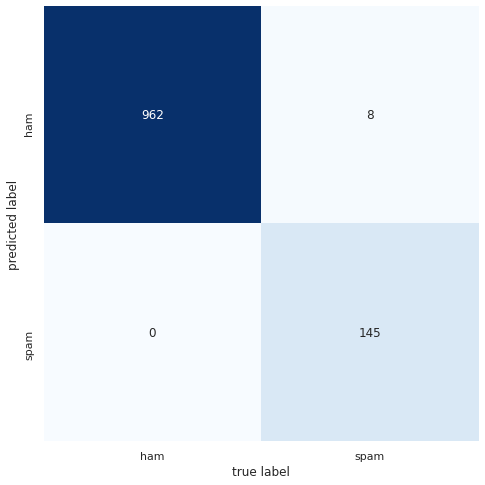

In [ ]:
import seaborn as sns; sns.set()

plt.figure(figsize=(8,8))
mat = confusion_matrix(Y_test, y_pred_text)
sns.heatmap(mat.T, square=True, annot=True, cmap='Blues',fmt='d', cbar=False,
            xticklabels=y.columns,
            yticklabels=y.columns)
plt.xlabel('true label')
plt.ylabel('predicted label')

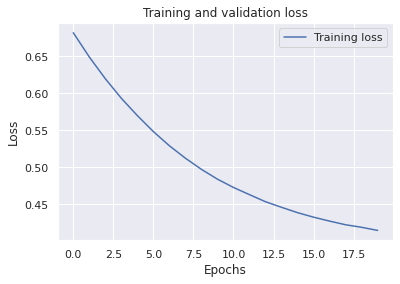

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

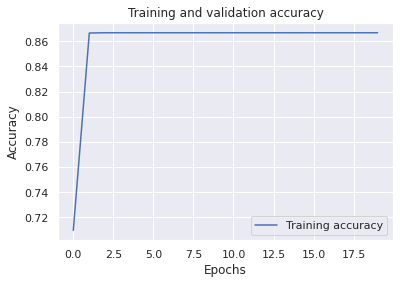

In [ ]:
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Taller
## Segundo Problema


Ante la gran demanda de noticias que se generan hoy en día, el servicio público de radio y televisión Británica BBC desea realizar un sistema que le permita clasificar diferentes noticias para mostrarlas en su página web. Para ello, le ha brindado las noticias previamente clasificadas en cinco categorías.

Se propone como ejercicio:

1. Realizar ***un clasificador utilizando un MLP*** para la solución de este problema.
2. Realizar una tabla comparando los resultados de los modelos del taller 4 con los arrojados por el ***MLP***.
